In [1]:
library(tidyverse)
library(catboost)
library(pROC)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [2]:
train <- read_csv("../input/jobathon-may-2021-credit-card-lead-prediction//train.csv")
test <- read_csv("../input//jobathon-may-2021-credit-card-lead-prediction//test.csv")
sample_sub <- read_csv("../input//jobathon-may-2021-credit-card-lead-prediction//sample_submission.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Gender = col_character(),
  Age = col_double(),
  Region_Code = col_character(),
  Occupation = col_character(),
  Channel_Code = col_character(),
  Vintage = col_double(),
  Credit_Product = col_character(),
  Avg_Account_Balance = col_double(),
  Is_Active = col_character(),
  Is_Lead = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Gender = col_character(),
  Age = col_double(),
  Region_Code = col_character(),
  Occupation = col_character(),
  Channel_Code = col_character(),
  Vintage = col_double(),
  Credit_Product = col_character(),
  Avg_Account_Balance = col_double(),
  Is_Active = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Is_Lead = col_double()
)




In [11]:
basic_prepro <- function(x,...){
  x %>% 
    replace_na(list(Credit_Product="-999")) %>%
    mutate_if(is.numeric,as.integer) %>%
    mutate_if(is.character,as.factor) %>%
#     mutate_if(is.factor,as.numeric) %>%
    select(-ID) %>%
    mutate(Avg_Account_Balance=as.integer(log(Avg_Account_Balance)))
    
}

In [12]:
tr <- train %>% basic_prepro(.)
te <- test %>% basic_prepro(.)

In [5]:
X <- colnames(te)
Y <- "Is_Lead"
cat_features <- names(Filter(is.character,train))[-1]
cat_features

[1] "Gender"         "Region_Code"    "Occupation"     "Channel_Code"  
[5] "Credit_Product" "Is_Active"

In [13]:
tr_split <- rsample::initial_split(tr,prop=0.8,strata = Is_Lead,breaks = 4)
tr_sample <- rsample::training(tr_split)
va_sample <- rsample::testing(tr_split)

In [14]:
str(va_sample)

tibble[,10] [49,144 × 10] (S3: tbl_df/tbl/data.frame)
 $ Gender             : Factor w/ 2 levels "Female","Male": 1 2 2 2 2 2 1 1 2 1 ...
 $ Age                : int [1:49144] 30 34 56 53 44 27 27 32 27 76 ...
 $ Region_Code        : Factor w/ 35 levels "RG250","RG251",..: 28 21 12 5 20 8 28 30 30 34 ...
 $ Occupation         : Factor w/ 4 levels "Entrepreneur",..: 3 3 4 4 4 3 3 3 3 2 ...
 $ Channel_Code       : Factor w/ 4 levels "X1","X2","X3",..: 1 1 1 3 2 1 1 4 1 3 ...
 $ Vintage            : int [1:49144] 32 19 32 123 19 21 19 15 21 93 ...
 $ Credit_Product     : Factor w/ 3 levels "-999","No","Yes": 2 2 2 2 3 2 2 1 3 1 ...
 $ Avg_Account_Balance: int [1:49144] 13 13 13 13 13 14 12 13 12 13 ...
 $ Is_Active          : Factor w/ 2 levels "No","Yes": 1 1 2 2 1 1 1 2 1 2 ...
 $ Is_Lead            : int [1:49144] 0 0 0 0 1 0 0 1 0 1 ...


In [15]:
tr_pool <- catboost.load_pool(data =  tr_sample[,X],
                              label = unlist(tr_sample[,Y]),cat_features=cat_features)
va_pool <-  catboost.load_pool(data =  va_sample[,X],
                              label = unlist(va_sample[,Y]),cat_features=cat_features)

In [16]:
full_tr <- catboost.load_pool(data =  tr[,X],
                              label = unlist(tr[,Y]),cat_features=cat_features)

In [17]:
te_pool <- catboost.load_pool(data =  te[,X],cat_features=cat_features)
te_pool

catboost.Pool
105312 rows, 9 columns

In [40]:
params <- list(iterations=3000,
               learning_rate=0.01,
               depth=6,
               loss_function="Logloss",
               eval_metric='AUC',
               random_seed = 55,
               l2_leaf_reg=8,
               langevin=TRUE,
               early_stopping_rounds=200,
               auto_class_weights = "Balanced",
               od_type='Iter',
               metric_period = 50,
               od_wait=20,
               rsm=0.5,
               use_best_model=TRUE)

In [41]:
model_train <- catboost.train(tr_pool,va_pool,params=params)

0:	test: 0.8506508	best: 0.8506508 (0)	total: 125ms	remaining: 6m 13s
50:	test: 0.8655498	best: 0.8656019 (47)	total: 5.5s	remaining: 5m 18s
100:	test: 0.8663776	best: 0.8664061 (97)	total: 11s	remaining: 5m 16s
150:	test: 0.8670580	best: 0.8670580 (150)	total: 16.4s	remaining: 5m 9s
200:	test: 0.8681669	best: 0.8681669 (200)	total: 21.7s	remaining: 5m 2s
250:	test: 0.8686365	best: 0.8686365 (250)	total: 27.1s	remaining: 4m 57s
300:	test: 0.8691010	best: 0.8691010 (300)	total: 32.7s	remaining: 4m 52s
350:	test: 0.8696148	best: 0.8696148 (350)	total: 38.6s	remaining: 4m 51s
400:	test: 0.8700771	best: 0.8700771 (400)	total: 44.5s	remaining: 4m 48s
450:	test: 0.8704098	best: 0.8704098 (450)	total: 50.1s	remaining: 4m 43s
500:	test: 0.8706586	best: 0.8706586 (500)	total: 55.6s	remaining: 4m 37s
550:	test: 0.8708411	best: 0.8708411 (550)	total: 1m	remaining: 4m 31s
600:	test: 0.8710063	best: 0.8710068 (599)	total: 1m 6s	remaining: 4m 24s
650:	test: 0.8711308	best: 0.8711308 (650)	total: 1m 

In [42]:
catboost.save_model(model_train,"./catboost_model2.cbm")

[1] TRUE

In [43]:
feat_imp <- as_tibble(catboost.get_feature_importance(model_train))%>% 
    rownames_to_column() %>% cbind(.,X) %>% arrange(desc(V1))
feat_imp

rowname,V1,X
<chr>,<dbl>,<fct>
7,35.9157624,Credit_Product
4,21.8282866,Occupation
6,15.5053555,Vintage
2,13.0300430,Age
5,8.0384558,Channel_Code
9,2.9924220,Is_Active
3,1.6986962,Region_Code
8,0.5956073,Avg_Account_Balance
1,0.3953711,Gender


In [44]:
va_pred_class <- catboost.predict(model_train, 
                               va_pool, 
                               prediction_type = 'Class')
va_pred_prob <- catboost.predict(model_train, 
                               va_pool, 
                               prediction_type = 'Probability')

In [45]:
confusionMatrix(factor(va_sample$Is_Lead),factor(va_pred_class))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 30596  6891
         1  2478  9179
                                          
               Accuracy : 0.8094          
                 95% CI : (0.8059, 0.8128)
    No Information Rate : 0.673           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.534           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9251          
            Specificity : 0.5712          
         Pos Pred Value : 0.8162          
         Neg Pred Value : 0.7874          
             Prevalence : 0.6730          
         Detection Rate : 0.6226          
   Detection Prevalence : 0.7628          
      Balanced Accuracy : 0.7481          
                                          
       'Positive' Class : 0               
                  

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”


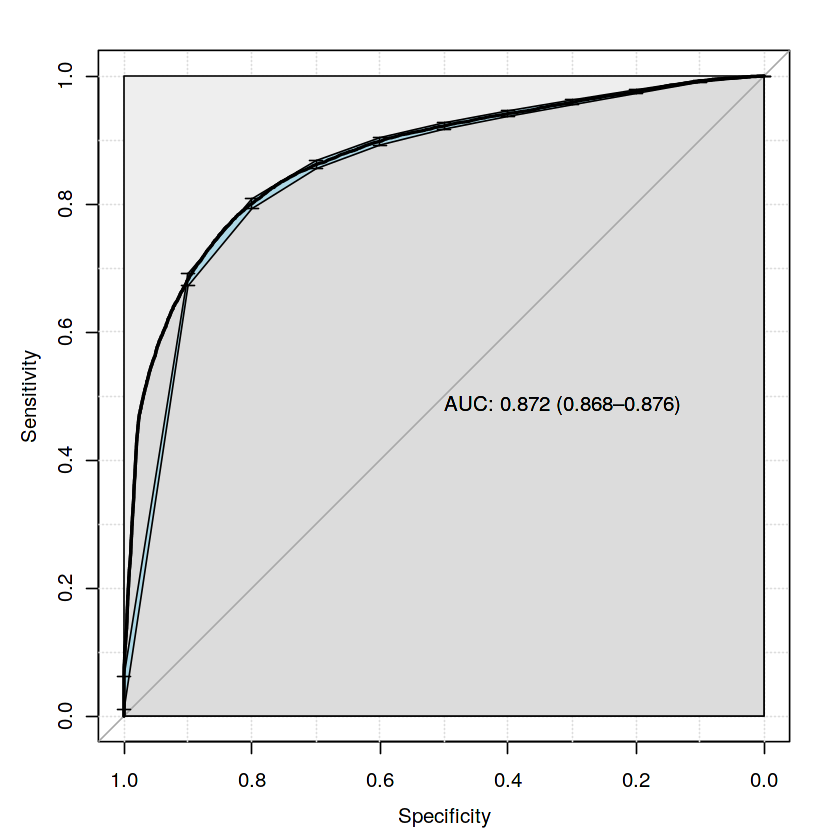

In [46]:
pROC_obj <- roc(va_sample$Is_Lead,va_pred_prob,
            smoothed = TRUE,
            # arguments for ci
            ci=TRUE, ci.alpha=0.9, stratified=FALSE,
            # arguments for plot
            plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE)


sens.ci <- ci.se(pROC_obj)
plot(sens.ci, type="shape", col="lightblue")
## Warning in plot.ci.se(sens.ci, type = "shape", col = "lightblue"): Low
## definition shape.
plot(sens.ci, type="bars")

In [47]:
#run the iteration on full dataset
params_f <- list(iterations=2957,
               learning_rate=0.01,
               depth=6,
               loss_function="Logloss",
               eval_metric='AUC',
               random_seed = 55,
               l2_leaf_reg=8,
               langevin=TRUE,
               early_stopping_rounds=200,
               auto_class_weights = "Balanced",
               od_type='Iter',
               metric_period = 50,
               od_wait=20,
               rsm=0.5)
model_final_train <- catboost.train(full_tr,params = params_f)

0:	total: 160ms	remaining: 7m 52s
50:	total: 5.98s	remaining: 5m 40s
100:	total: 12.2s	remaining: 5m 45s
150:	total: 18.5s	remaining: 5m 43s
200:	total: 24.9s	remaining: 5m 40s
250:	total: 30.9s	remaining: 5m 33s
300:	total: 37.4s	remaining: 5m 29s
350:	total: 44.1s	remaining: 5m 27s
400:	total: 50.5s	remaining: 5m 22s
450:	total: 57.1s	remaining: 5m 17s
500:	total: 1m 3s	remaining: 5m 11s
550:	total: 1m 9s	remaining: 5m 5s
600:	total: 1m 16s	remaining: 5m
650:	total: 1m 23s	remaining: 4m 54s
700:	total: 1m 29s	remaining: 4m 46s
750:	total: 1m 35s	remaining: 4m 40s
800:	total: 1m 41s	remaining: 4m 33s
850:	total: 1m 47s	remaining: 4m 26s
900:	total: 1m 53s	remaining: 4m 19s
950:	total: 1m 59s	remaining: 4m 12s
1000:	total: 2m 5s	remaining: 4m 5s
1050:	total: 2m 11s	remaining: 3m 58s
1100:	total: 2m 18s	remaining: 3m 52s
1150:	total: 2m 24s	remaining: 3m 46s
1200:	total: 2m 30s	remaining: 3m 39s
1250:	total: 2m 36s	remaining: 3m 33s
1300:	total: 2m 42s	remaining: 3m 27s
1350:	total: 2m 

In [49]:
te_pred <- catboost.predict(model_final_train, 
                               te_pool, 
                               prediction_type = 'Probability')

In [50]:
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=te_pred)
filename <- paste('catboost_baseline_2957',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)